In [1]:
# Reed Whitcraft
# Mod 03 Project
# Friday, May 10, 2019

# NBA Game Outcome Classifier

## Can I accurately classify games as won/lost using statistics through the third quarter?

#### 2018-2019 NBA Game Logs

## Obtain Data

### Import Libraries

In [245]:
import pandas as pd
import numpy as np
import json
from ipywidgets import interact, interactive
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load Traditional & Advanced Stats (JSON)

In [161]:
# url endpoint: 
# https://stats.nba.com/stats/teamgamelogs?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlusMinus=N&Rank=N&Season=2018-19&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&VsConference=&VsDivision=


nba_first_half_json = json.load(open('data/first-half-traditional.json'))
nba_third_q_json = json.load(open('data/third-quarter-traditional.json'))

#### Extract Headers/Columns

In [162]:
def extract_json_rows(json, key='rowSet'):
    # stats.nba.com returns body inside resultSets[0][field-key]
    return json['resultSets'][0][key]

In [163]:
nba_columns = extract_json_rows(nba_first_half_json, key='headers')
print(nba_columns)

['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK']


#### Extract Rows

In [164]:
rows_half = extract_json_rows(nba_first_half_json, key='rowSet')
rows_third = extract_json_rows(nba_third_q_json, key='rowSet')
pd.DataFrame(rows_half[:3]).head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,2018-19,1610612746,LAC,LA Clippers,0021801229,2019-04-10T00:00:00,LAC vs. UTA,W,24.0,27,...,1267,16,1791,833,1080,1382,1572,614,107,815
1,2018-19,1610612765,DET,Detroit Pistons,0021801223,2019-04-10T00:00:00,DET @ NYK,W,24.0,22,...,237,1849,690,1840,1080,246,862,614,331,31
2,2018-19,1610612744,GSW,Golden State Warriors,0021801225,2019-04-10T00:00:00,GSW @ MEM,L,24.0,26,...,2457,41,76,1840,1080,1,1848,1229,180,2312


#### Create Initial DataFrames

In [165]:
nba_half_df = pd.DataFrame(rows_half, columns=nba_columns)
nba_third_df = pd.DataFrame(rows_third, columns=nba_columns)

In [166]:
nba_half_df.head(3)

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,2018-19,1610612746,LAC,LA Clippers,0021801229,2019-04-10T00:00:00,LAC vs. UTA,W,24.0,27,...,1267,16,1791,833,1080,1382,1572,614,107,815
1,2018-19,1610612765,DET,Detroit Pistons,0021801223,2019-04-10T00:00:00,DET @ NYK,W,24.0,22,...,237,1849,690,1840,1080,246,862,614,331,31
2,2018-19,1610612744,GSW,Golden State Warriors,0021801225,2019-04-10T00:00:00,GSW @ MEM,L,24.0,26,...,2457,41,76,1840,1080,1,1848,1229,180,2312


In [167]:
nba_third_df.head(3)

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,2018-19,1610612762,UTA,Utah Jazz,0021801229,2019-04-10T00:00:00,UTA @ LAC,L,12.0,12,...,186,337,313,1415,325,1,1407,646,621,1292
1,2018-19,1610612751,BKN,Brooklyn Nets,0021801221,2019-04-10T00:00:00,BKN vs. MIA,W,12.0,10,...,22,337,313,2081,875,1587,171,1574,920,625
2,2018-19,1610612753,ORL,Orlando Magic,0021801222,2019-04-10T00:00:00,ORL @ CHA,W,12.0,14,...,2175,1426,69,770,325,1,31,1574,216,625


In [168]:
nba_third_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 56 columns):
SEASON_YEAR          2460 non-null object
TEAM_ID              2460 non-null int64
TEAM_ABBREVIATION    2460 non-null object
TEAM_NAME            2460 non-null object
GAME_ID              2460 non-null object
GAME_DATE            2460 non-null object
MATCHUP              2460 non-null object
WL                   2460 non-null object
MIN                  2460 non-null float64
FGM                  2460 non-null int64
FGA                  2460 non-null int64
FG_PCT               2460 non-null float64
FG3M                 2460 non-null int64
FG3A                 2460 non-null int64
FG3_PCT              2460 non-null float64
FTM                  2460 non-null int64
FTA                  2460 non-null int64
FT_PCT               2460 non-null float64
OREB                 2460 non-null int64
DREB                 2460 non-null int64
REB                  2460 non-null int64
AST              

### Merging, Cleaning, & Dropping Data

#### Drop Extra Columns (anything with '_RANK')

In [169]:
nba_half_df = nba_half_df[nba_half_df.columns.drop(list(nba_half_df.filter(regex='_RANK')))]
nba_third_df = nba_third_df[nba_third_df.columns.drop(list(nba_third_df.filter(regex='_RANK')))]

In [170]:
nba_third_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 30 columns):
SEASON_YEAR          2460 non-null object
TEAM_ID              2460 non-null int64
TEAM_ABBREVIATION    2460 non-null object
TEAM_NAME            2460 non-null object
GAME_ID              2460 non-null object
GAME_DATE            2460 non-null object
MATCHUP              2460 non-null object
WL                   2460 non-null object
MIN                  2460 non-null float64
FGM                  2460 non-null int64
FGA                  2460 non-null int64
FG_PCT               2460 non-null float64
FG3M                 2460 non-null int64
FG3A                 2460 non-null int64
FG3_PCT              2460 non-null float64
FTM                  2460 non-null int64
FTA                  2460 non-null int64
FT_PCT               2460 non-null float64
OREB                 2460 non-null int64
DREB                 2460 non-null int64
REB                  2460 non-null int64
AST              

#### Drop Noticeably Irrelevant Columns

We also want to drop the non relevant columns, like: SEASON_YEAR, TEAM_ID, TEAM_ABBREVIATION, TEAM_NAME, GAME_DATE.  Later, we'll want to also drop GAME_ID and TEAM_ID, but we need these to identify rows that should be merged later on (adding the AWAY team stats to the HOME rows, since each game has a row for each team.

In [171]:
columns_to_drop = ['SEASON_YEAR', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE']
nba_half_df.drop(columns_to_drop, axis=1, inplace=True)
nba_third_df.drop(columns_to_drop, axis=1, inplace=True)

#### Rename 3rd Quarter Columns for Merging

In [172]:
nba_third_df = nba_third_df.add_prefix("3Q_") # to distinguish once DataFrames are merged

#### Remove "3Q_" Prefix for Columns That Will Be Used for Joining DataFrames

In [173]:
# remove the 3Q_ prefix for overlapping columns
nba_third_df = nba_third_df.rename(index=str, columns={"3Q_TEAM_ID": "TEAM_ID",
                                        "3Q_GAME_ID": "GAME_ID",
                                        "3Q_MATCHUP": "MATCHUP",
                                        "3Q_WL": "WL",
                                       })

#### Merge DataFrames

The nba.stats.com serves traditional box score stats for 1st Half and individual quarters from different endpoints, so they will have to be merged, and, later, the 3rd quarter stats will have to be added to the half time stats.  Rows will be combined on **GAME_ID** and **TEAM_ID** since each game will have a unique identifier, and each game has two rows of data (one for each team).

In [175]:
dup_columns = ["TEAM_ID", "GAME_ID", "MATCHUP", "WL"]
three_q = nba_half_df.merge(nba_third_df, how='inner', on=dup_columns)

In [176]:
three_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Data columns (total 48 columns):
TEAM_ID          2460 non-null int64
GAME_ID          2460 non-null object
MATCHUP          2460 non-null object
WL               2460 non-null object
MIN              2460 non-null float64
FGM              2460 non-null int64
FGA              2460 non-null int64
FG_PCT           2460 non-null float64
FG3M             2460 non-null int64
FG3A             2460 non-null int64
FG3_PCT          2460 non-null float64
FTM              2460 non-null int64
FTA              2460 non-null int64
FT_PCT           2460 non-null float64
OREB             2460 non-null int64
DREB             2460 non-null int64
REB              2460 non-null int64
AST              2460 non-null int64
TOV              2460 non-null float64
STL              2460 non-null int64
BLK              2460 non-null int64
BLKA             2460 non-null int64
PF               2460 non-null int64
PFD              2460 non-nul

#### Adding Half Time Stats + 3rd Quarter Stats

In [178]:
columns_to_add = ['MIN', 'FGM', 'FGA', 'FG3M',  'FG3A', 'FTM',  'FTA',  
                  'OREB',  'DREB',  'REB',  'AST',  'TOV',  'STL',  
                  'BLK',  'BLKA',  'PF',  'PFD',  'PTS', 'PLUS_MINUS']

for col in columns_to_add:
    three_q[col] = three_q[col] + three_q["3Q_" + col]

print(three_q.iloc[0])

TEAM_ID           1610612746
GAME_ID           0021801229
MATCHUP          LAC vs. UTA
WL                         W
MIN                       36
FGM                       38
FGA                       70
FG_PCT                 0.587
FG3M                      10
FG3A                      20
FG3_PCT                0.571
FTM                       16
FTA                       22
FT_PCT                 0.615
OREB                       7
DREB                      27
REB                       34
AST                       27
TOV                       10
STL                        4
BLK                        2
BLKA                       5
PF                        17
PFD                       17
PTS                      102
PLUS_MINUS                 5
3Q_MIN                    12
3Q_FGM                    11
3Q_FGA                    24
3Q_FG_PCT              0.458
3Q_FG3M                    2
3Q_FG3A                    6
3Q_FG3_PCT             0.333
3Q_FTM                     8
3Q_FTA        

#### Calculating FG, FG3, & FT% with Combined Half-Time & Third Quarter Stats

In [179]:
three_q["FG_PCT"] = three_q["FGM"] / three_q["FGA"]
three_q["FG3_PCT"] = three_q["FG3M"] / three_q["FG3A"]
three_q["FT_PCT"] = three_q["FTM"] / three_q["FTA"]

print(three_q.iloc[0])

TEAM_ID           1610612746
GAME_ID           0021801229
MATCHUP          LAC vs. UTA
WL                         W
MIN                       36
FGM                       38
FGA                       70
FG_PCT              0.542857
FG3M                      10
FG3A                      20
FG3_PCT                  0.5
FTM                       16
FTA                       22
FT_PCT              0.727273
OREB                       7
DREB                      27
REB                       34
AST                       27
TOV                       10
STL                        4
BLK                        2
BLKA                       5
PF                        17
PFD                       17
PTS                      102
PLUS_MINUS                 5
3Q_MIN                    12
3Q_FGM                    11
3Q_FGA                    24
3Q_FG_PCT              0.458
3Q_FG3M                    2
3Q_FG3A                    6
3Q_FG3_PCT             0.333
3Q_FTM                     8
3Q_FTA        

#### Dropping Old 3Q Columns

In [180]:
three_q = three_q[three_q.columns.drop(list(three_q.filter(regex='3Q_')))]

In [181]:
three_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Data columns (total 26 columns):
TEAM_ID       2460 non-null int64
GAME_ID       2460 non-null object
MATCHUP       2460 non-null object
WL            2460 non-null object
MIN           2460 non-null float64
FGM           2460 non-null int64
FGA           2460 non-null int64
FG_PCT        2460 non-null float64
FG3M          2460 non-null int64
FG3A          2460 non-null int64
FG3_PCT       2460 non-null float64
FTM           2460 non-null int64
FTA           2460 non-null int64
FT_PCT        2459 non-null float64
OREB          2460 non-null int64
DREB          2460 non-null int64
REB           2460 non-null int64
AST           2460 non-null int64
TOV           2460 non-null float64
STL           2460 non-null int64
BLK           2460 non-null int64
BLKA          2460 non-null int64
PF            2460 non-null int64
PFD           2460 non-null int64
PTS           2460 non-null int64
PLUS_MINUS    2460 non-null fl

#### Set Home Team Attribute (Matchup has "vs.")

In [182]:
# 1 = HOME, 0 = AWAY
three_q['HOME'] = pd.np.where(three_q.MATCHUP.str.contains("vs."), 1, 0)

In [183]:
three_q.describe()

,TEAM_ID,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,HOME
count,2.460000e+03,2460.0,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,...,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,1.610613e+09,36.0,31.258537,67.415041,0.464752,8.563008,23.789024,0.359516,12.544309,16.273171,...,18.878862,10.631707,5.817886,3.689024,3.689024,14.980081,14.980488,83.624390,0.000000,0.500000
std,8.657201e+00,0.0,4.361444,5.604972,0.061031,3.172372,5.862582,0.100391,4.968963,5.966711,...,4.337055,3.349041,2.527314,2.111290,2.111290,3.405138,3.405678,10.493611,13.559442,0.500102
min,1.610613e+09,36.0,17.000000,48.000000,0.283784,1.000000,7.000000,0.047619,0.000000,0.000000,...,6.000000,1.000000,0.000000,0.000000,0.000000,6.000000,6.000000,53.000000,-40.000000,0.000000
25%,1.610613e+09,36.0,28.000000,64.000000,0.424114,6.000000,20.000000,0.294118,9.000000,12.000000,...,16.000000,8.000000,4.000000,2.000000,2.000000,13.000000,13.000000,77.000000,-9.000000,0.000000
50%,1.610613e+09,36.0,31.000000,67.000000,0.463768,8.000000,23.000000,0.357143,12.000000,16.000000,...,19.000000,10.000000,6.000000,3.000000,3.000000,15.000000,15.000000,84.000000,0.000000,0.500000
75%,1.610613e+09,36.0,34.000000,71.000000,0.506898,11.000000,28.000000,0.421559,15.000000,20.000000,...,22.000000,13.000000,7.000000,5.000000,5.000000,17.000000,17.000000,91.000000,9.000000,1.000000
max,1.610613e+09,36.0,47.000000,86.000000,0.689655,24.000000,50.000000,0.933333,32.000000,37.000000,...,35.000000,25.000000,16.000000,14.000000,14.000000,28.000000,28.000000,125.000000,40.000000,1.000000


### Combine Away Row Data as "OPP_[STAT]" in Home Row Data

#### Sort DataFrame By GAME_ID so that Home/Away rows are adjacent

In [184]:
# positions home/away rows for each game together
three_q.sort_values(['GAME_ID'], inplace=True)

In [185]:
three_q.head()

,TEAM_ID,GAME_ID,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,HOME
2459,1610612738,0021800001,BOS vs. PHI,W,36.0,31,75,0.413333,6,25,...,15,10.0,6,4,4,13,14,77,11.0,1
2457,1610612755,0021800001,PHI @ BOS,L,36.0,27,68,0.397059,4,19,...,14,14.0,7,4,4,14,13,66,-11.0,0
2456,1610612760,0021800002,OKC @ GSW,L,36.0,27,73,0.369863,9,31,...,17,11.0,11,4,4,16,19,79,-4.0,0
2458,1610612744,0021800002,GSW vs. OKC,W,36.0,32,71,0.450704,7,21,...,22,17.0,5,4,4,19,16,83,4.0,1
2436,1610612766,0021800003,CHA vs. MIL,L,36.0,32,71,0.450704,11,29,...,17,8.0,7,3,3,15,17,83,-10.0,1


In [186]:
three_q_df = three_q.copy()

opp_columns = ['MIN', 'FGM', 'FGA', 'FG3M',  'FG3A', 'FTM',  'FTA',  
                  'OREB',  'DREB',  'REB',  'AST',  'TOV',  'STL',  
                  'BLK',  'BLKA',  'PF',  'PFD',  'PTS', 'PLUS_MINUS']

# iterate through dataframe, every other index (since, rows ordered by game id)
for i in range(0, len(three_q_df), 2):
    # get game id of row with current index
    gid = three_q_df.iloc[i]['GAME_ID']
    
    for col in opp_columns:
        # locate row of away team (on matching game id & home == 0) and get column value
        away_stat = three_q_df.loc[(three_q_df['GAME_ID'] == gid) & (three_q_df['HOME'] == 0), col].values[0]
        new_col = "OPP_" + col
        # assign opponent stat is new column in current row (home team)
        three_q_df.loc[(three_q_df['GAME_ID'] == gid) & (three_q_df['HOME'] == 1), new_col] = away_stat

In [187]:
three_q_df.head(5)

,TEAM_ID,GAME_ID,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,OPP_PLUS_MINUS
2459,1610612738,0021800001,BOS vs. PHI,W,36.0,31,75,0.413333,6,25,...,39.0,14.0,14.0,7.0,4.0,4.0,14.0,13.0,66.0,-11.0
2457,1610612755,0021800001,PHI @ BOS,L,36.0,27,68,0.397059,4,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2456,1610612760,0021800002,OKC @ GSW,L,36.0,27,73,0.369863,9,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2458,1610612744,0021800002,GSW vs. OKC,W,36.0,32,71,0.450704,7,21,...,34.0,17.0,11.0,11.0,4.0,4.0,16.0,19.0,79.0,-4.0
2436,1610612766,0021800003,CHA vs. MIL,L,36.0,32,71,0.450704,11,29,...,46.0,22.0,16.0,3.0,3.0,3.0,17.0,15.0,93.0,10.0


#### Drop (Away) Rows for Matchups (which will have NaNs for OPP_[STAT])

In [188]:
# drop away team rows which now have NaNs
three_q_df.dropna(inplace=True)

In [189]:
three_q_df.head()

,TEAM_ID,GAME_ID,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,OPP_PLUS_MINUS
2459,1610612738,0021800001,BOS vs. PHI,W,36.0,31,75,0.413333,6,25,...,39.0,14.0,14.0,7.0,4.0,4.0,14.0,13.0,66.0,-11.0
2458,1610612744,0021800002,GSW vs. OKC,W,36.0,32,71,0.450704,7,21,...,34.0,17.0,11.0,11.0,4.0,4.0,16.0,19.0,79.0,-4.0
2436,1610612766,0021800003,CHA vs. MIL,L,36.0,32,71,0.450704,11,29,...,46.0,22.0,16.0,3.0,3.0,3.0,17.0,15.0,93.0,10.0
2442,1610612765,0021800004,DET vs. BKN,W,36.0,31,71,0.436620,5,19,...,30.0,23.0,15.0,6.0,4.0,2.0,20.0,15.0,76.0,-7.0
2435,1610612754,0021800005,IND vs. MEM,W,36.0,32,60,0.533333,7,18,...,21.0,12.0,9.0,8.0,2.0,7.0,14.0,16.0,58.0,-18.0


#### Drop Remaining Extra Columns

In [191]:
three_q_df.drop(['OPP_PLUS_MINUS', 'BLKA', 'OPP_BLKA', 'PFD', 'OPP_PFD', 
                 'GAME_ID', 'TEAM_ID', 'MIN', 'OPP_MIN', 'HOME'], axis=1, inplace=True)

### Calculate Four Factor Statistics

[Introduction to Four Factors: Score, Protect, Crash, and Attack](https://squared2020.com/2017/09/05/introduction-to-olivers-four-factors/)

The four factors are to **score efficiently, protect the basketball on offense, grab as many rebounds as possible, and get to the foul line as often as possible**.  Each of these factors are closely related to the termination of a possession for a team. 

Calculating:

    1. Effective FG%: (FGM + 0.5*FG3M)/FGA
    2. Turnover %: (FGA - OR + TO + 0.4*FTA)/TO
    3. Offensive Rebound %: OR/(OR + OPP_DREB)
    3b. Defensive Rebound %: DREB / (OPP FG Misses)
    4. Free Throw Rate: FTA/FGA
    

In [192]:
# Calculate Four-Factor stats for home team
three_q_df["EFG_PCT"] = (three_q_df.FGM + 0.5*three_q_df.FG3M)/three_q_df.FGA
three_q_df["TOV_PCT"] = three_q_df.TOV/(three_q_df.FGA - three_q_df.OREB + three_q_df.TOV + 0.4*three_q_df.FTA)
three_q_df["OREB_PCT"] = three_q_df.OREB / (three_q_df.OREB + three_q_df.OPP_DREB)
three_q_df["FT_RATE"] = three_q_df.FTA / three_q_df.FGA

# Calculate Four-Factor stats for away team (OPP)
three_q_df["OPP_EFG_PCT"] = (three_q_df.OPP_FGM + 0.5*three_q_df.OPP_FG3M)/three_q_df.OPP_FGA
three_q_df["OPP_TOV_PCT"] = three_q_df.OPP_TOV/(three_q_df.OPP_FGA - three_q_df.OPP_OREB + three_q_df.OPP_TOV + 0.4*three_q_df.OPP_FTA)
three_q_df["OPP_FT_RATE"] = three_q_df.OPP_FTA / three_q_df.OPP_FGA
three_q_df["DREB_PCT"] = three_q_df.DREB / (three_q_df.OPP_FGA - three_q_df.OPP_FGM)


In [193]:
three_q_df.isna().any() # confirmation of no NaNs

MATCHUP        False
WL             False
FGM            False
FGA            False
FG_PCT         False
FG3M           False
FG3A           False
FG3_PCT        False
FTM            False
FTA            False
FT_PCT         False
OREB           False
DREB           False
REB            False
AST            False
TOV            False
STL            False
BLK            False
PF             False
PTS            False
PLUS_MINUS     False
OPP_FGM        False
OPP_FGA        False
OPP_FG3M       False
OPP_FG3A       False
OPP_FTM        False
OPP_FTA        False
OPP_OREB       False
OPP_DREB       False
OPP_REB        False
OPP_AST        False
OPP_TOV        False
OPP_STL        False
OPP_BLK        False
OPP_PF         False
OPP_PTS        False
EFG_PCT        False
TOV_PCT        False
OREB_PCT       False
FT_RATE        False
OPP_EFG_PCT    False
OPP_TOV_PCT    False
OPP_FT_RATE    False
DREB_PCT       False
dtype: bool

In [194]:
three_q_df.head()

,MATCHUP,WL,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,OPP_PF,OPP_PTS,EFG_PCT,TOV_PCT,OREB_PCT,FT_RATE,OPP_EFG_PCT,OPP_TOV_PCT,OPP_FT_RATE,DREB_PCT
2459,BOS vs. PHI,W,31,75,0.413333,6,25,0.240000,9,12,...,14.0,66.0,0.453333,0.126904,0.250000,0.160000,0.426471,0.173267,0.176471,0.707317
2458,GSW vs. OKC,W,32,71,0.450704,7,21,0.333333,12,13,...,16.0,79.0,0.500000,0.209360,0.352941,0.183099,0.431507,0.134804,0.328767,0.717391
2436,CHA vs. MIL,L,32,71,0.450704,11,29,0.379310,8,12,...,17.0,93.0,0.528169,0.101523,0.121951,0.169014,0.628788,0.206186,0.212121,0.677419
2442,DET vs. BKN,W,31,71,0.436620,5,19,0.263158,16,18,...,20.0,76.0,0.471831,0.129534,0.289474,0.253521,0.524590,0.188917,0.262295,0.806452
2435,IND vs. MEM,W,32,60,0.533333,7,18,0.388889,5,10,...,14.0,58.0,0.591667,0.222222,0.320000,0.166667,0.365079,0.121622,0.238095,0.750000


### Drop Columns Used in Feature Engineering of Four Factor Statistics

Field Goal statistics, Free Throw statistics, Rebounds, and a couple of other columns were used to get the four factor advanced analytics, so those will be dropped.

In [195]:
extra_columns = ['FGM', 'FGA', 'FG_PCT', 
            'FG3M', 'FG3A', 'FG3_PCT', 
            'FTM', 'FTA', 'FT_PCT',
            'OPP_FGM', 'OPP_FGA',
            'OPP_FG3M', 'OPP_FG3A',
            'OPP_FTM', 'OPP_FTA',
            'PF', 'OPP_PF',
            'OREB', 'DREB', 'OPP_OREB', 'OPP_DREB',
            'TOV', 'OPP_TOV', 'STL', 'OPP_STL',
            'PTS', 'OPP_PTS', 'REB', 'OPP_REB'
            ]

three_q_df = three_q_df.drop(extra_columns, axis=1)

In [196]:
three_q_df.head(3)
three_q_df.describe()

,AST,BLK,PLUS_MINUS,OPP_AST,OPP_BLK,EFG_PCT,TOV_PCT,OREB_PCT,FT_RATE,OPP_EFG_PCT,OPP_TOV_PCT,OPP_FT_RATE,DREB_PCT
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.00000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000
mean,19.277461,3.752644,2.094386,18.470301,3.62978,0.534235,0.137480,0.229253,0.247874,0.522548,0.138481,0.242027,0.731797
std,4.331009,2.186501,13.404842,4.303639,2.03122,0.072704,0.040657,0.079975,0.097111,0.071355,0.043278,0.097188,0.093943
min,6.000000,0.000000,-38.000000,7.000000,0.00000,0.304054,0.013966,0.000000,0.040541,0.326389,0.012690,0.027397,0.428571
25%,16.000000,2.000000,-7.000000,15.000000,2.00000,0.485294,0.110294,0.176471,0.180556,0.473333,0.107239,0.173913,0.666667
50%,19.000000,4.000000,2.000000,18.000000,3.00000,0.530303,0.136054,0.225000,0.238806,0.522388,0.135802,0.235294,0.730769
75%,22.000000,5.000000,11.000000,21.000000,5.00000,0.584507,0.162907,0.281250,0.303030,0.569231,0.166240,0.303030,0.800000
max,34.000000,14.000000,40.000000,35.000000,11.00000,0.790323,0.284900,0.560000,0.672727,0.784483,0.298295,0.686275,1.000000


In [197]:
three_q_df.columns

Index(['MATCHUP', 'WL', 'AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
       'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE', 'OPP_EFG_PCT',
       'OPP_TOV_PCT', 'OPP_FT_RATE', 'DREB_PCT'],
      dtype='object')

## Final Features List (13)

    1. ASSISTS
    2. BLOCKS    
    3. EFFECTIVE FIELD GOAL %
    4. TURNOVER %
    5. OFFENSIVE REBOUND %
    6. FREE THROW RATE
    7. ASSISTS (OPPONENT)
    8. BLOCKS (OPPONENT)
    9. EFFECTIVE FIELD GOAL % (OPPONENT)
    10. TURNOVER % (OPPONENT)
    11. DEFENSIVE REBOUND % (OPPONENT)
    12. FREE THROW RATE (OPPONENT)
    13. PLUS MINUS

# EDA

### Create Subsets for Visualization

In [198]:
eda_df = three_q_df.drop(['MATCHUP'], axis=1)

eda_df_w = eda_df.loc[eda_df["WL"] == "W"] # games that were won
eda_df_l = eda_df.loc[eda_df["WL"] == "L"] # games that were lost
print("Total Games: ", len(eda_df))
print("Total (Home) Wins: ", len(eda_df_w))
print("Total (Home) Losses: ", len(eda_df_l))
print("% (Home) Games Won: ", (len(eda_df_w)/len(eda_df)))

Total Games:  1229
Total (Home) Wins:  729
Total (Home) Losses:  500
% (Home) Games Won:  0.5931651749389748


In [199]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229 entries, 2459 to 18
Data columns (total 14 columns):
WL             1229 non-null object
AST            1229 non-null int64
BLK            1229 non-null int64
PLUS_MINUS     1229 non-null float64
OPP_AST        1229 non-null float64
OPP_BLK        1229 non-null float64
EFG_PCT        1229 non-null float64
TOV_PCT        1229 non-null float64
OREB_PCT       1229 non-null float64
FT_RATE        1229 non-null float64
OPP_EFG_PCT    1229 non-null float64
OPP_TOV_PCT    1229 non-null float64
OPP_FT_RATE    1229 non-null float64
DREB_PCT       1229 non-null float64
dtypes: float64(11), int64(2), object(1)
memory usage: 144.0+ KB


In [200]:
all_columns = ['WL', 'AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
               'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
               'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

# without WL
feature_names = ['AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
                 'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

### Distribution Plot of Team Statistics

In [201]:
@interact
def distribution_preview(feature = feature_names):
    sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [14, 5]})
    p = sns.distplot(eda_df[feature], label=feature, bins=20)
    plt.title("Distribution of {} (All Game Outcomes)".format(feature))
    p.legend()
    
    fig2 = plt.figure(figsize=(14,5))
    p = sns.distplot(eda_df_w[feature], label="{} in W".format(feature), bins=20)
    sns.distplot(eda_df_l[feature], label="{} in L".format(feature), bins=20)
    plt.title("Distribution of {} (W vs. L)".format(feature))
    p.legend()
    
    plt.show()

interactive(children=(Dropdown(description='feature', options=('AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK…

### Pairplot of Advanced Statistics

Looking at all the features at once will restrict what can be garnered from the visualizations, so I'll begin looking at the more traditional statistics (rebounds, assists, turnovers, steals, and blocks).

<Figure size 1152x576 with 0 Axes>

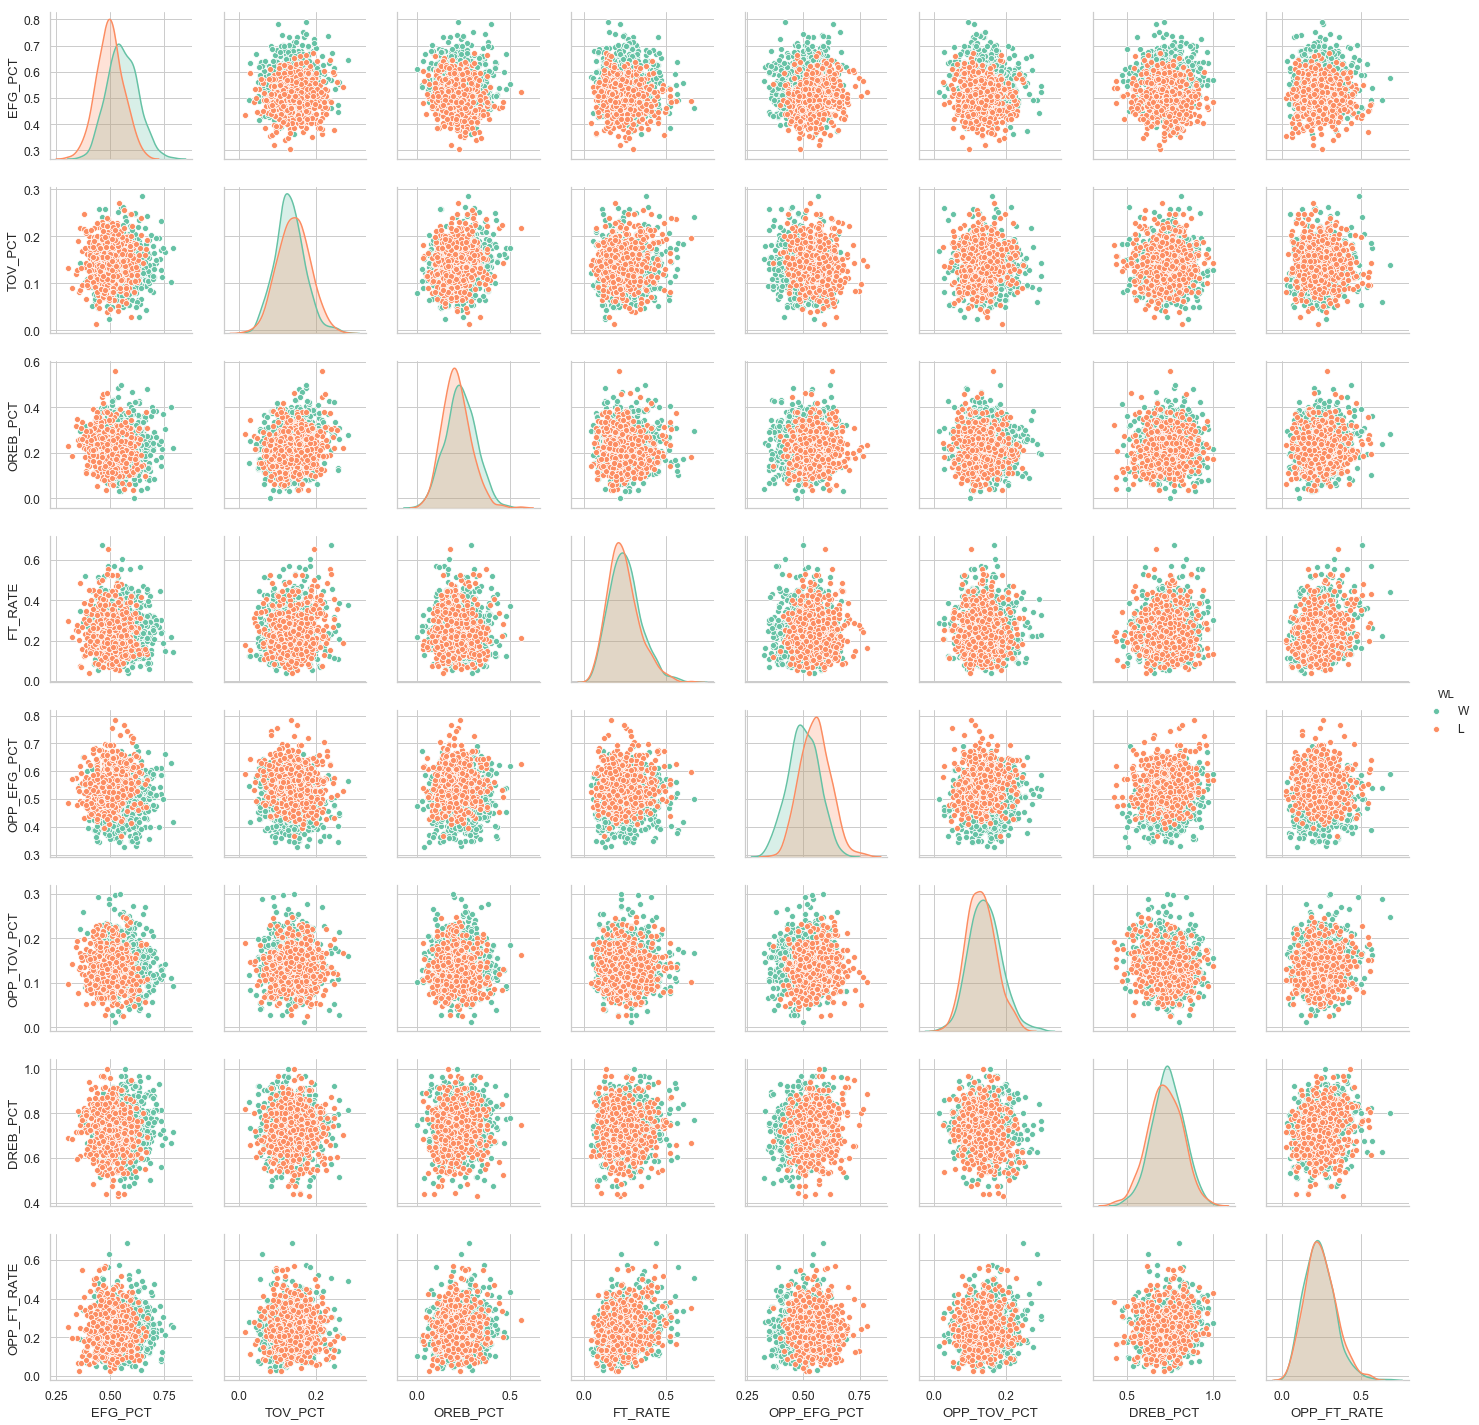

In [202]:
four_factor_feats = ['WL', 
                     'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                     'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']    

eda_pair_df = eda_df[four_factor_feats]
fig = plt.figure(figsize=(16,8))
sns.pairplot(eda_pair_df, kind='scatter', hue='WL', palette="Set2")

### Swarm Plot

#### Helper Function

In [203]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[x]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

#### Interactive Plot

In [205]:
feature_names = ['AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK',
                 'EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE',
                 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'DREB_PCT', 'OPP_FT_RATE']

@interact
def swarm_preview(feature = feature_names):
    sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [16, 6]})
    quantitative_summarized(dataframe= eda_df, y = 'WL', x = feature, palette="Set2", verbose=False, swarm=True)

interactive(children=(Dropdown(description='feature', options=('AST', 'BLK', 'PLUS_MINUS', 'OPP_AST', 'OPP_BLK…

### Heat Map (Annotated)

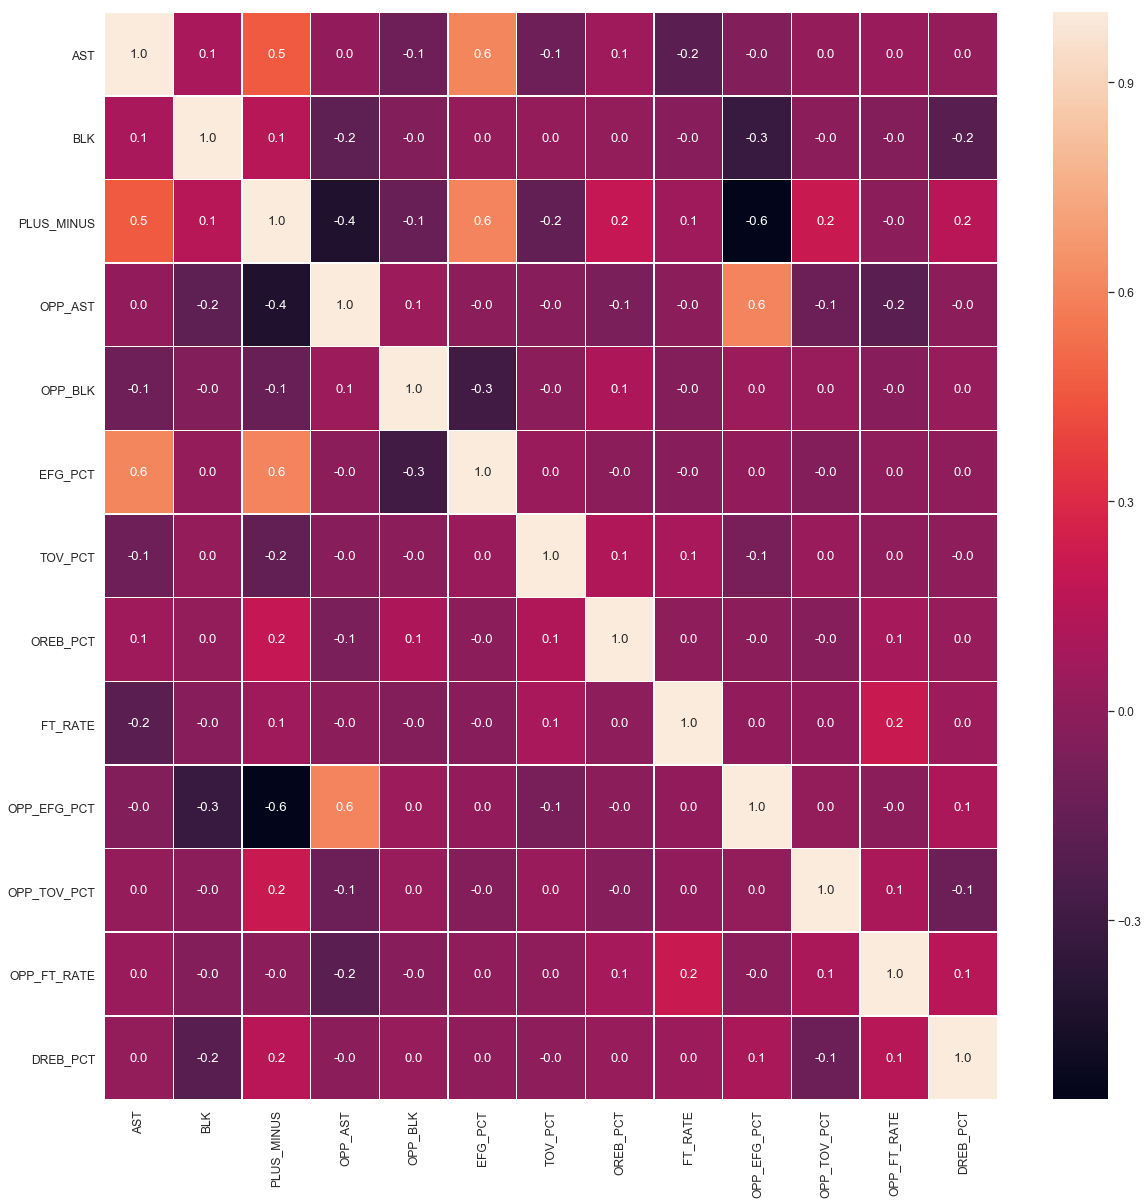

In [206]:
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(eda_df.corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

#### Heat Map Takeaway

Very few of the remaining features show correlation, with the highest being 0.6/-0.6 between FG% and AST - which makes sense, as an AST is only possible if a FG is made.  Given that the correlations are all below 0.7, it does not look like we need to remove any features at the moment.

### Interactive Pie Charts

In [385]:
def f(x, xx):
    games_won = eda_df.loc[(eda_df['WL'] == 'W') & (eda_df[xx] >= x)]
    games_lost = eda_df.loc[(eda_df['WL'] == 'L') & (eda_df[xx] >= x)]
    games_won2 = eda_df.loc[(eda_df['WL'] == 'W') & (eda_df[xx] < x)]
    games_lost2 = eda_df.loc[(eda_df['WL'] == 'L') & (eda_df[xx] < x)]
    games_total = len(eda_df)
    games_won_total = len(games_won)
    games_lost_total = len(games_lost)
    
    games_won_total2 = len(games_won2)
    games_lost_total2 = len(games_lost2)
    
    games_stat_total = games_won_total + games_lost_total
    games_no_stat_total = games_total - games_stat_total
    
    fig, ax = plt.subplots(figsize=(12,12))
    size = 0.3
    
    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(2)*4)
    inner_colors = cmap(np.array([1, 2, 5, 6]))


    ax.pie([games_stat_total, games_no_stat_total], radius=1, colors=outer_colors, wedgeprops=dict(width=size, edgecolor='w'), labels=["Games {} % >= {}".format(xx,x), "Games {} % < {}".format(xx,x)], autopct='%1.0f%%', pctdistance=0.85)
    ax.pie([games_won_total, games_lost_total, games_won_total2, games_lost_total2], radius=1-size, colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'), labels=["W", "L", "W", "L"], labeldistance=0.8, rotatelabels=False, autopct='%1.0f%%', pctdistance=0.5)
    ax.legend()
#     vals = np.array([[games_lost]])
    
    print("# Games Won: ", len(games_won))
    print("# Games Lost: ", len(games_lost))
    
#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.pie([games_won_total, games_lost_total], labels=["Games Won", "Games Lost"])
#     ax.axis('equal')
#     ax.legend(frameon=False, bbox_to_anchor(1.5, 0.8))
    return x

In [386]:
pcts = ['EFG_PCT', 'TOV_PCT', 'OREB_PCT', 'FT_RATE', 'OPP_EFG_PCT', 'OPP_TOV_PCT', 'OPP_FT_RATE', 'DREB_PCT']
interact(f, x=(0.0, 1.0, 0.01), xx=pcts)

interactive(children=(FloatSlider(value=0.5, description='x', max=1.0, step=0.01), Dropdown(description='xx', …

<function __main__.f(x, xx)>

In [ ]:
# def f(x):
#     games_won = eda_df.loc[(eda_df['WL'] == 'W') & (eda_df["EFG_PCT"] >= x)]
#     games_lost = eda_df.loc[(eda_df['WL'] == 'L') & (eda_df["EFG_PCT"] >= x)]
#     games_total = len(eda_df)
#     games_won_total = len(games_won)
#     games_lost_total = len(games_lost)
#     ganes_stat_total = games_won_total + games_stat_total
    
#     print("# Games Won: ", len(games_won))
#     print("# Games Lost: ", len(games_lost))
    
#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.pie([games_won_total, games_lost_total], labels=["Games Won", "Games Lost"])
#     ax.axis('equal')
# #     ax.legend(frameon=False, bbox_to_anchor(1.5, 0.8))
#     return x

# Feature Scaling, Pre-Modeling

### Import Libraries

In [207]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

np.random.seed(0)

### Scale Feature Variables

In [208]:
#### REVIEW => NOT ACTUALLY USED 
#### REVIEW => NOT ACTUALLY USED 
#### REVIEW => NOT ACTUALLY USED 
#### REVIEW => NOT ACTUALLY USED 
#### REVIEW => NOT ACTUALLY USED 
#### REVIEW => NOT ACTUALLY USED 

df = eda_df.copy()
labels = df['WL']
labels_removed_df = df.drop('WL', axis=1, inplace=False)
# scaler = StandardScaler()
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(labels_removed_df)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Modeling

## Decision Tree Classifier (Vanilla)

#### Import Necessary Libraries

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
import pydotplus

In [211]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['WL'])
X = df.drop('WL', axis=1)
y = labels

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=10)

#### Train Classifier & Make Predictions

In [213]:
classifier = DecisionTreeClassifier(random_state=10)  
classifier.fit(X_train, y_train)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [214]:
# Make predictions for test data
y_pred = classifier.predict(X_test)  

#### Check Predictive Performance

In [215]:
# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is :73.17073170731707

AUC is :0.74

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,117,33,150
1,66,153,219
All,183,186,369


#### Visualize Tree

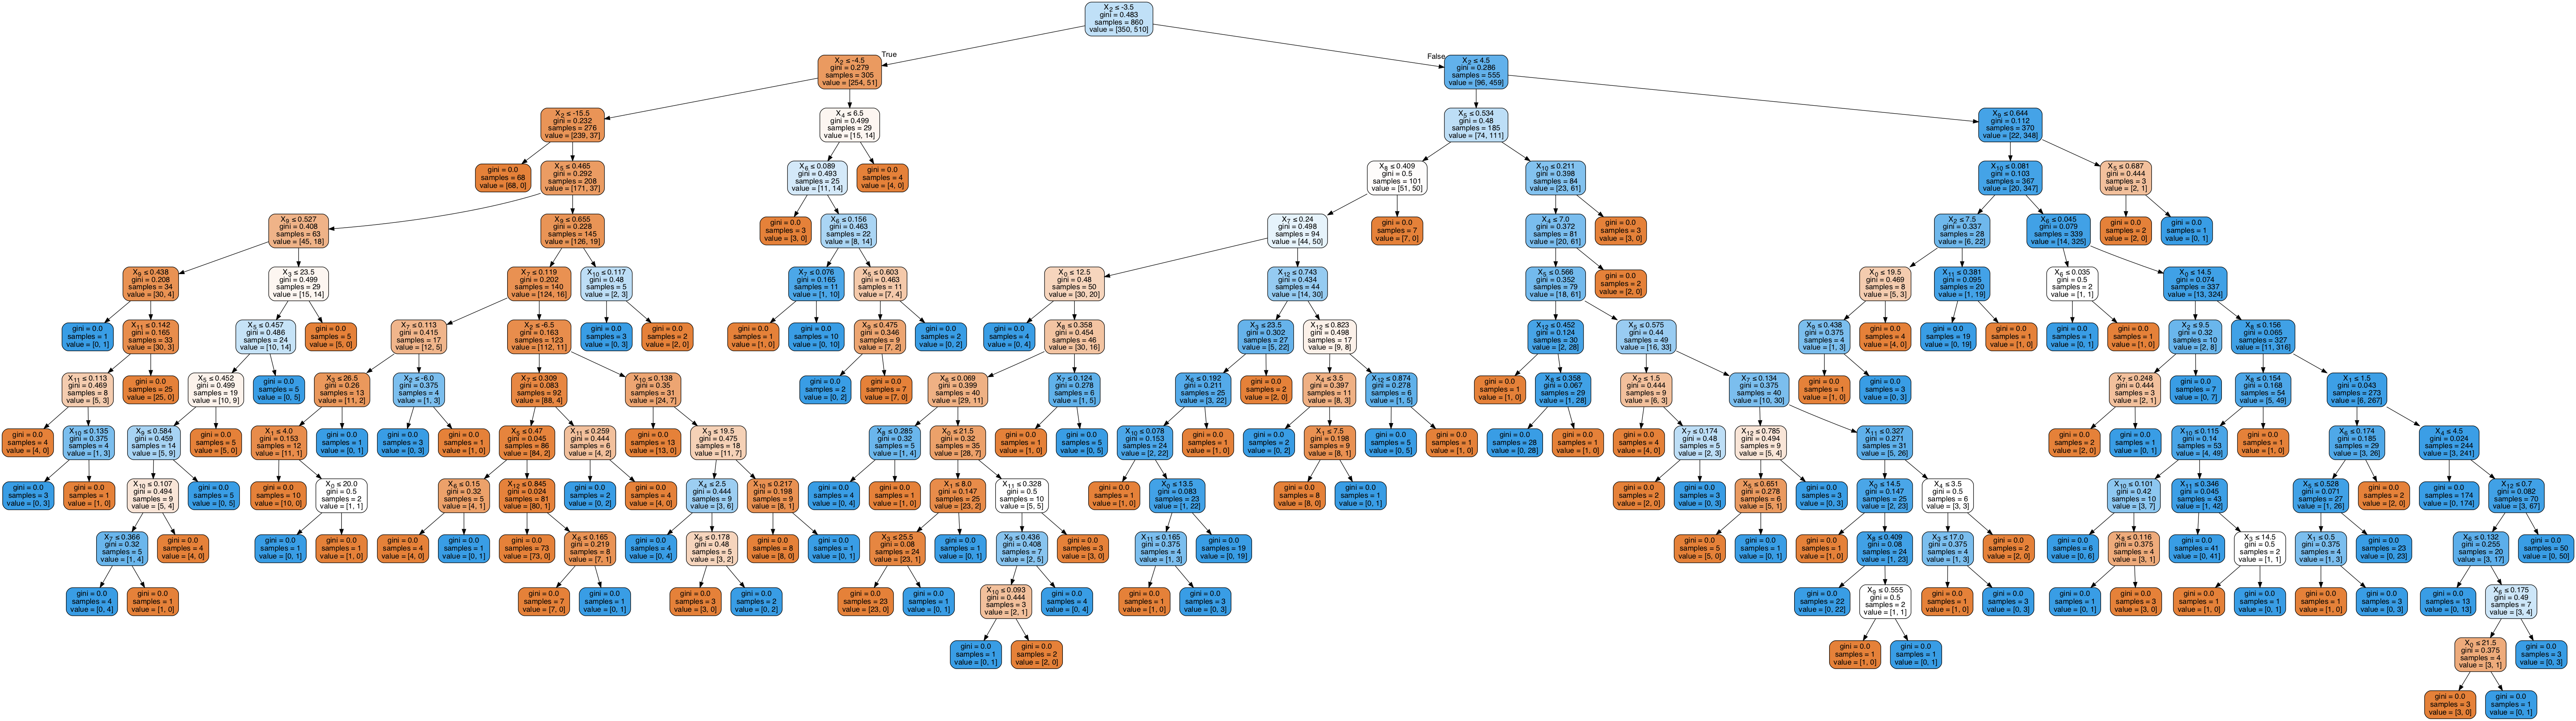

In [216]:
# Visualize the tree trained from complete dataset
dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Model Pipelines & Principal Component Analysis

#### Import Necessary Libraries

In [217]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # imported in tree below
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(X)
# df = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2'])
# result_df = pd.concat([df, iris[['target']]], axis = 1) result_df.head(5)

In [218]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['WL'])
X = df.drop('WL', axis=1)
y = labels

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=10)

### Principal Component Analysis

#### Principal Components & Explained Variance

Here, we'll iterate over a range of possible principal components to see what our explained variance is at each number of components.  We want to reduce the dimensionality of our data, so if we can reduce the number of components needed while maintaining a high percentage of explained variance, we'll be better off when modeling. 

In [225]:
def principal_component_and_explained_variance(n_components, X):
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X)
    explained_var = round(np.sum(pca.explained_variance_ratio_)*100, 2)
    print("PCA with {} components has explained variance ratio of {}%".format(n_components, explained_var))
    
for i in range(1,11):
    principal_component_and_explained_variance(i, X)

PCA with 1 components has explained variance ratio of 83.12%
PCA with 2 components has explained variance ratio of 91.47%
PCA with 3 components has explained variance ratio of 96.2%
PCA with 4 components has explained variance ratio of 98.21%
PCA with 5 components has explained variance ratio of 99.98%
PCA with 6 components has explained variance ratio of 99.99%
PCA with 7 components has explained variance ratio of 99.99%
PCA with 8 components has explained variance ratio of 99.99%
PCA with 9 components has explained variance ratio of 100.0%
PCA with 10 components has explained variance ratio of 100.0%


Looks like the explained variance ratio is pretty high at multiple component levels, so we'll settle with 2 components, which explained 91.47% of the variance in our data.

In [226]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

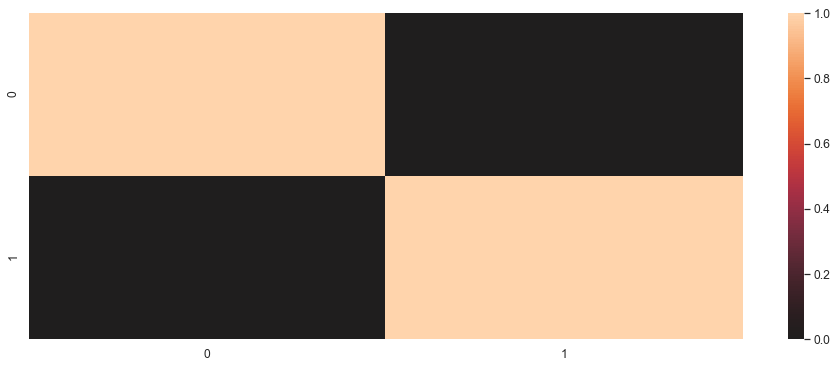

In [227]:
sns.heatmap(pd.DataFrame(principalComponents).corr(), center=0);

In [236]:
print(pca.explained_variance_ratio_)

[0.83120594 0.08354397]


### SVM, Decision Tree, & Random Forest Classifier Pipelines

Now, we'll create a couple pipelines using three different classifiers, without grid search, then repeat with grid search to find our best model.

In [233]:
pipe_svm = Pipeline([('pca', PCA(n_components=2)),
                    ('clf', svm.SVC(random_state=123))])

pipe_tree = Pipeline([('pca', PCA(n_components=2)),
                     ('clf', tree.DecisionTreeClassifier(random_state=123))])

pipe_rf = Pipeline([('pca', PCA(n_components=2)),
                   ('clf', RandomForestClassifier(random_state=123))])

pipelines = [pipe_svm, pipe_tree, pipe_rf]

pipeline_names = ['SVM', 'Decision Tree', 'Random Forest']

for pipe in pipelines:
    print(pipe)
    print("*_*_*_*_*_")
    pipe.fit(X_train, y_train)
    
# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False))])
*_*_*_*_*_
Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'))])
*_*_*_*_*_
Pipeline(memory=None,
     steps=[('pca', PCA(copy

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### SVM, Decision Tree, & Random Forest Pipelines Review

Without exhaustively searching/tuning our parameters, the three classifiers did better than random chance, but they should be improved by grid search.

**SVM Pipeline**: 80.2%

**Decision Tree Pipeline**: 75.3%

**Random Forest Pipeline**: 77.2%

## Pipelines (Grid Search)

### SVM Pipeline (with Grid Search)

In [229]:
pipe_svm = Pipeline([('pca', PCA(n_components=2)),
            ('clf', svm.SVC(random_state=123))])

# Set grid search params
param_grid_svm = [
  {'clf__C': [0.1, 1, 10], 
   'clf__kernel': ['linear']
  },
  {'clf__C': [1, 10], 
   'clf__gamma': [0.001, 0.01], 
   'clf__kernel': ['rbf']
  },
]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__kernel=linear ..................................
[CV] ................... clf__C=0.1, clf__kernel=linear, total=   0.0s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.0s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.0s
[CV] clf__C=1, clf__kernel=linear ....................................
[CV] ..................... clf__C=1, clf__kernel=linear, total=   0.0s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... clf__C=10, clf__kernel=linear, total=   0.1s
[CV] clf__C=10, clf__kernel=linear ...................................
[CV] .................... clf__C=10, clf__kernel=linear, total=   0.1s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................
[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=   0.0s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................
[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=   0.0s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................
[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=   0.0s
[CV] clf__C=1, clf__gamma=0.01, clf__kernel=rbf ......................
[CV] ....... clf__C=1, clf__gamma=0.01, clf__kernel=rbf, total=   0.0s
[CV] clf__C=1, clf__gamma=0.01, clf__kernel=rbf ......................
[CV] ....... clf__C=1, clf__gamma=0.01, clf__kernel=rbf, total=   0.0s
[CV] clf__C=1, clf__gamma=0.01, clf__kernel=rbf ......................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.5s finished


#### Best Parameters (SVM - Grid Search)

clf__C: 1

clf__game: 0.01

clf__kernel: 'rbf'


In [395]:
regressor = svm.SVC(random_state=123,
                    C=1,
                    gamma=0.01,
                    kernel='rbf'
                   )


regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.33726027397260283,
 0.15989159891598917,
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
   max_iter=-1, probability=False, random_state=123, shrinking=True,
   tol=0.001, verbose=False))

In [230]:
gs_svm.cv_results_

{'mean_fit_time': array([0.01313909, 0.01891065, 0.076413  , 0.00824499, 0.00822369,
        0.00860818, 0.01276135]),
 'std_fit_time': array([5.41539802e-03, 1.95947689e-03, 1.58614989e-02, 1.25440918e-03,
        9.36466850e-05, 1.41340146e-03, 1.13921598e-03]),
 'mean_score_time': array([0.00165431, 0.00148733, 0.00155942, 0.00248631, 0.00174252,
        0.0019455 , 0.00180364]),
 'std_score_time': array([2.50403255e-04, 1.86033149e-04, 1.67034218e-04, 2.81037450e-04,
        3.36636752e-05, 2.15636480e-04, 1.04374161e-04]),
 'param_clf__C': masked_array(data=[0.1, 1, 10, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__kernel': masked_array(data=['linear', 'linear', 'linear', 'rbf', 'rbf', 'rbf',
                    'rbf'],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__gamma': masked_array(data=

### Random Forest Pipeline (Grid Search)

In [244]:
# Construct pipeline
pipe_rf = Pipeline([('pca', PCA(n_components=2)),
            ('clf', RandomForestClassifier(random_state = 123))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.02, 0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.02, 0.05 ,0.1, 0.2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.02, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, cl

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, clf__min_samples_split=0.02, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.02, cl

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, cl

Best accuracy: 0.822

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.02, 'clf__min_samples_split': 0.1, 'clf__n_estimators': 120}


[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:   33.4s finished


In [232]:
gs_rf.cv_results_

{'mean_fit_time': array([0.09609604, 0.09112008, 0.09639772, 0.08678563, 0.09198268,
        0.08997766, 0.08359933, 0.08161863, 0.08102353, 0.09502077,
        0.09229747, 0.08740799, 0.08663162, 0.08661906, 0.088974  ,
        0.07827369, 0.08385046, 0.08603295, 0.09511224, 0.09149234,
        0.09681733, 0.08826876, 0.09418297, 0.08820017, 0.08570798,
        0.08745742, 0.08290895, 0.08980616, 0.09350332, 0.09155401,
        0.09216245, 0.08330735, 0.08716321, 0.0830303 , 0.08217557,
        0.08354155, 0.09399009, 0.0942026 , 0.08629735, 0.08842667,
        0.08819564, 0.08390816, 0.08442227, 0.0798583 , 0.08678945,
        0.09068704, 0.09323168, 0.08781775, 0.08581225, 0.0881664 ,
        0.09045267, 0.08100017, 0.08862805, 0.08421405]),
 'std_fit_time': array([0.00512566, 0.00105302, 0.00427026, 0.0006856 , 0.00237682,
        0.00454514, 0.00420212, 0.00587405, 0.00172352, 0.0048687 ,
        0.00053804, 0.00143521, 0.00145035, 0.00252717, 0.00310762,
        0.00143213, 0.000

#### Best Params for Random Forest Pipeline (Grid Search)

clf__criterion: 'gini'

clf__max_depth: 6

clf__min_samples_leaf: 0.02

clf__min_samples_split: 0.05

clf__n_estimators: 120

In [238]:
# Evaluation Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
def performance(y_true, y_predict):
    """ Calculates and returns the performance score between
    true and predicted values based on the metric chosen. """
    # TODO: Calculate the performance score between 'y_true' and 'y_predict
    r2 = r2_score(y_true,y_predict)
    mse = mean_squared_error(y_true,y_predict) # Return the score
    return [r2, mse]

In [243]:
regressor = RandomForestClassifier(random_state=123,
                                   min_samples_split=0.05,
                                   min_samples_leaf=0.02,
                                   max_depth=6,
                                   criterion='gini',
                                   n_estimators=120)


regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.3484931506849316,
 0.15718157181571815,
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=6, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=0.02, min_samples_split=0.05,
             min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
             oob_score=False, random_state=123, verbose=0, warm_start=False))

# Random Snippets